# Geospatial analysis of uber tlc foil data

In [242]:
%matplotlib inline

import pandas as pd
import geopandas
import mapclassify as mc
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
from datetime import datetime

pd.options.display.max_rows = 200

## Importing & formatting uber tlc foil ride data

In [136]:
boroughs = geopandas.read_file("./data/Borough_Boundaries.geojson")

In [174]:
neighborhoods = geopandas.read_file("./data/Neighborhood_Tabulation_Areas.geojson")

In [178]:
rides = pd.read_csv("./data/uber-raw-data-apr14.csv").pipe(geopandas.GeoDataFrame) #for testing purposes

In [99]:
rides = pd.concat(
    [
        pd.read_csv("./data/uber-raw-data-apr14.csv"),
        pd.read_csv("./data/uber-raw-data-may14.csv"),
        pd.read_csv("./data/uber-raw-data-jun14.csv"),
        pd.read_csv("./data/uber-raw-data-jul14.csv"),
        pd.read_csv("./data/uber-raw-data-aug14.csv"),
        pd.read_csv("./data/uber-raw-data-sep14.csv"),
    ]
).pipe(geopandas.GeoDataFrame)



In [179]:
rides.count()

Date/Time    564516
Lat          564516
Lon          564516
Base         564516
dtype: int64

In [180]:
rides['geometry'] = list(zip(rides.Lon.astype(float), rides.Lat.astype(float)))

In [181]:
rides['geometry'] = rides['geometry'].apply(Point)

In [176]:
neighborhoods.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,BK88,54005019.0709,047,Borough Park,39247.2280277,Brooklyn,3,(POLYGON ((-73.97604935657381 40.6312759056467...
1,QN51,52488276.867,081,Murray Hill,33266.9049948,Queens,4,(POLYGON ((-73.80379022888246 40.7756101117924...
2,QN27,19726845.6252,081,East Elmhurst,19816.7123182,Queens,4,(POLYGON ((-73.86109724335759 40.7636644770869...
3,QN07,22887772.8652,081,Hollis,20976.3355739,Queens,4,(POLYGON ((-73.75725671509139 40.7181386016625...
4,MN06,10647077.4989,061,Manhattanville,17040.6854134,Manhattan,1,(POLYGON ((-73.94607828674226 40.8212632160619...


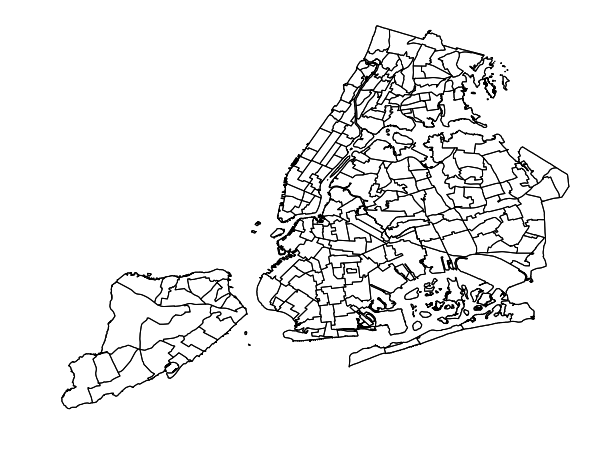

In [184]:
ax = boroughs.plot(edgecolor='k', facecolor='none', figsize=(10, 10))
neighborhoods.plot(ax=ax, edgecolor='k', facecolor='none')
ax.set_axis_off()

[(40.4, 41), (-74.3, -73.6)]

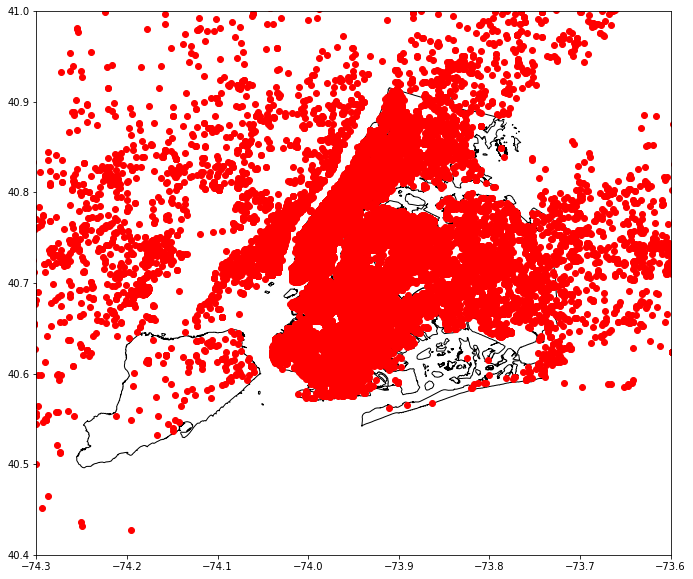

In [132]:
ax = boroughs.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
rides.plot(ax=ax, color='red')
ax.set(xlim=(-74.3, -73.6), ylim=(40.4, 41))

In [151]:
bases = geopandas.read_file("./data/CURRENT_BASES.csv")

In [152]:
bases['geometry'] = list(zip(bases.Longitude.astype(float), bases.Latitude.astype(float)))

In [153]:
bases['geometry'] = bases['geometry'].apply(Point)

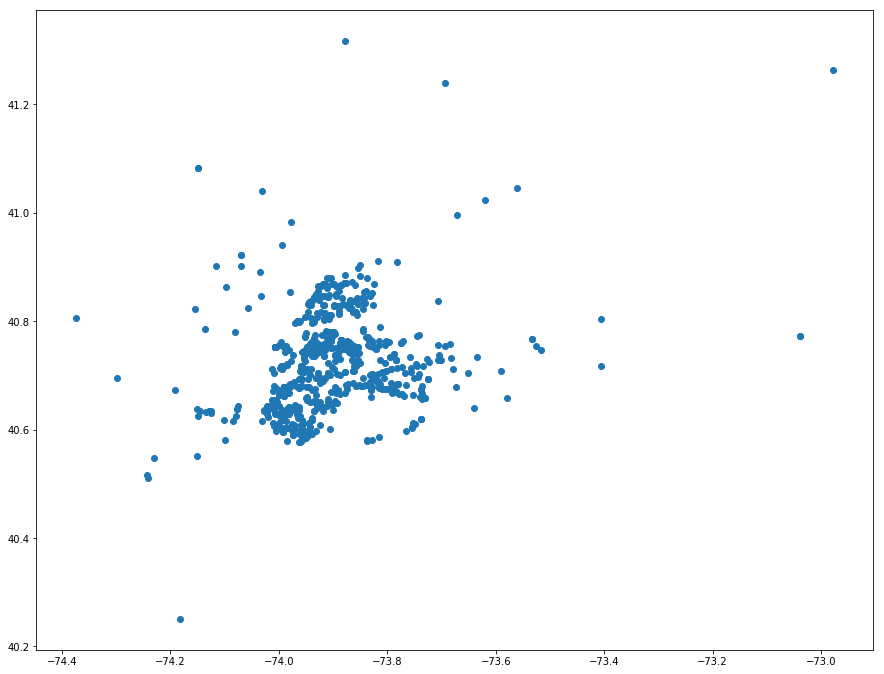

In [154]:
bases.plot(figsize=(15, 15))

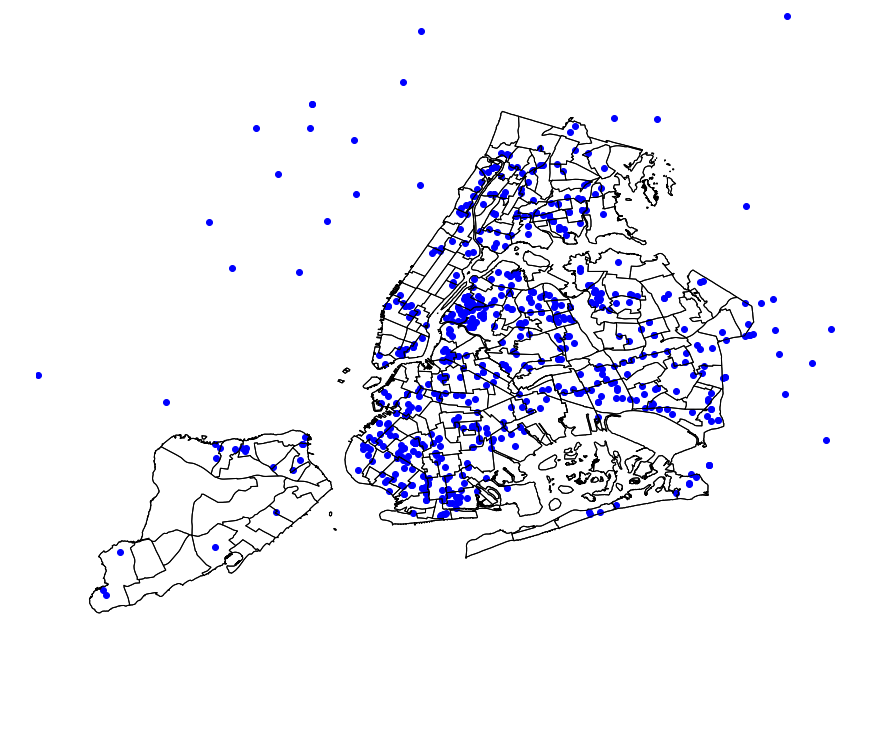

In [177]:
ax = boroughs.plot(edgecolor='k', facecolor='none', figsize=(15, 15))
bases.plot(ax=ax, color='blue')
neighborhoods.plot(ax=ax, edgecolor='k', facecolor='none')
ax.set(xlim=(-74.3, -73.6), ylim=(40.4, 41))
ax.set_axis_off()

In [207]:
import folium

In [208]:
m = folium.Map([40.7128,-74.0060], zoom_start=10, tiles="OpenStreetMap")
folium.GeoJson(boroughs.to_json()).add_to(m)
folium.GeoJson(bases.to_json()).add_to(m)

In [186]:
rides.crs = neighborhoods.crs
joined = geopandas.sjoin(rides, neighborhoods, op='within', how='left')

In [189]:
joined.head()

,Date/Time,Lat,Lon,Base,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,POINT (-73.95489999999999 40.769),43.0,MN31,21501377.3638,061,Lenox Hill-Roosevelt Island,37708.3342924,Manhattan,1
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,POINT (-74.03449999999999 40.7267),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,POINT (-73.9873 40.7316),156.0,MN22,10894316.0859,061,East Village,13555.2394504,Manhattan,1
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,POINT (-73.9776 40.7588),100.0,MN17,30191534.1874,061,Midtown-Midtown South,27032.7004332,Manhattan,1
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,POINT (-73.9722 40.7594),13.0,MN19,17393274.6306,061,Turtle Bay-East Midtown,21412.5981855,Manhattan,1


In [201]:
rideCount = joined.groupby('ntaname')['Date/Time'].count()

In [202]:
print(rideCount)

ntaname
Airport                                                     21607
Allerton-Pelham Gardens                                        23
Annadale-Huguenot-Prince's Bay-Eltingville                      1
Arden Heights                                                   2
Astoria                                                      1312
Auburndale                                                     31
Baisley Park                                                  149
Bath Beach                                                     55
Battery Park City-Lower Manhattan                           20172
Bay Ridge                                                     561
Bayside-Bayside Hills                                          86
Bedford                                                      2214
Bedford Park-Fordham North                                     74
Bellerose                                                      22
Belmont                                                       193
Be

In [209]:
rideCount

ntaname
Airport                                                     21607
Allerton-Pelham Gardens                                        23
Annadale-Huguenot-Prince's Bay-Eltingville                      1
Arden Heights                                                   2
Astoria                                                      1312
Auburndale                                                     31
Baisley Park                                                  149
Bath Beach                                                     55
Battery Park City-Lower Manhattan                           20172
Bay Ridge                                                     561
Bayside-Bayside Hills                                          86
Bedford                                                      2214
Bedford Park-Fordham North                                     74
Bellerose                                                      22
Belmont                                                       193
Be

In [224]:
ridesPerNeighborhood = neighborhoods.merge(rideCount, left_on='ntaname', right_on='ntaname')

In [225]:
#determine best classification scheme
y = ridesPerNeighborhood['Date/Time']
q5 = mc.Quantiles(y, k=5)
ei5 = mc.Equal_Interval(y, k=5)
mb5 = mc.Maximum_Breaks(y, k=5)
fj5 = mc.Fisher_Jenks(y, k=5)
fits = [c.adcm for c in [q5, ei5, mb5, fj5]]
fits

[428211.0, 218496.0, 214347.0, 112775.0]

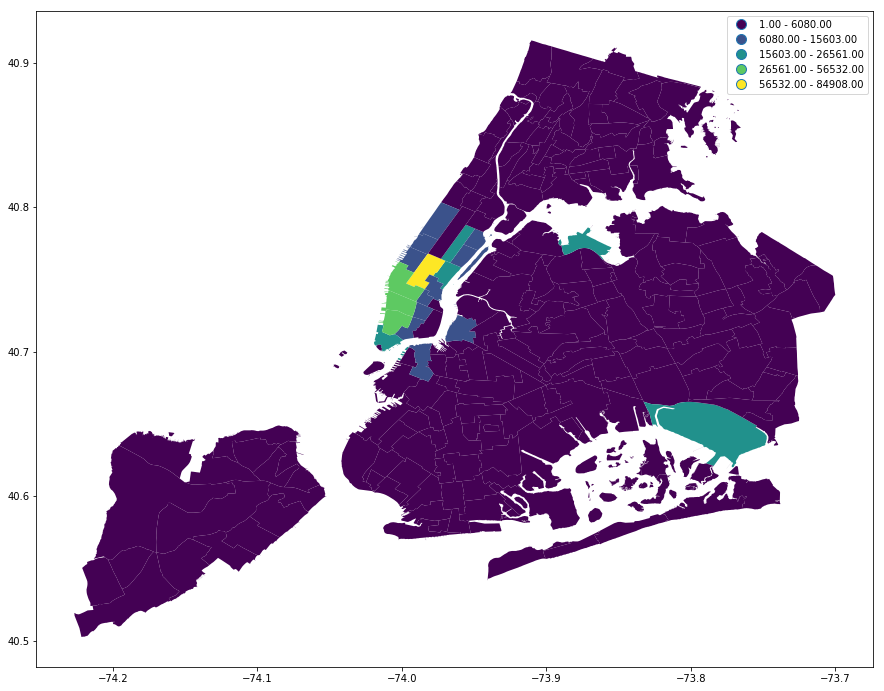

In [226]:
ridesPerNeighborhood.plot(column='Date/Time', figsize=(15, 15), scheme='Fisher_Jenks',  legend=True)

In [270]:
rides.head()

,Date/Time,Lat,Lon,Base,geometry
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,POINT (-73.95489999999999 40.769)
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,POINT (-74.03449999999999 40.7267)
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,POINT (-73.9873 40.7316)
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,POINT (-73.9776 40.7588)
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,POINT (-73.9722 40.7594)


In [246]:
type(rides)

geopandas.geodataframe.GeoDataFrame

In [232]:
datetime.strptime(rides[0]['Date/Time'], '%Y-%m-%d-%H-%M')

KeyError: 0

In [ ]:
x = rides['Date/Time']
y = #number of rides p
plt.plot(x, y)
plt.show()


In [243]:
# Seasonal Autoregressive Integrated Moving-Average (SARIMA) example
# (https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[100.47638553]


In [274]:
rides['Date'] = rides['Date/Time'].astype(datetime.date)

TypeError: data type not understood

In [269]:
#how to index in panda.series:
rides.iloc[2]

Date/Time            4/1/2014 0:21:00
Lat                           40.7316
Lon                          -73.9873
Base                           B02512
geometry     POINT (-73.9873 40.7316)
Name: 2, dtype: object

In [273]:
rides.head()

,Date/Time,Lat,Lon,Base,geometry,Date
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,POINT (-73.95489999999999 40.769),4/1/2014 0:11:00
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,POINT (-74.03449999999999 40.7267),4/1/2014 0:17:00
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,POINT (-73.9873 40.7316),4/1/2014 0:21:00
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,POINT (-73.9776 40.7588),4/1/2014 0:28:00
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,POINT (-73.9722 40.7594),4/1/2014 0:33:00
